In [4]:
# import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union #, unary_union
import osmnx as ox
from h3 import h3
from __future__ import division
import base64
import urllib
import tempfile
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import numpy as np
import networkx as nx
import peartree as pt
import geopandas as gpd
from shapely.geometry import Point

import os
import json
from we_module.we import We
import requests
from keplergl import KeplerGl

#### Define functions

In [5]:
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(11,9), colormap='viridis', s=20):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col,
                     edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize, s=s)
    plt.xticks([], [])
    plt.yticks([], [])

In [6]:
# smoothing function that distributes metric value into surrounding hex rings
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

#### Load graphs for bus networks in each borough

In [7]:
nyc_bus = {}
for f in os.listdir('./nyc_bus'):
    borough = '_'.join(f.split('.')[0].split('_')[2:])
    feed = pt.get_representative_feed('./nyc_bus/' + f)
    
    # Set a target time period to use to summarize impedance
    start = 7*60*60  # 7:00 AM
    end = 10*60*60  # 10:00 AM
   
    # Converts feed subset into a directed network multigraph
    G = pt.load_feed_as_graph(feed, start, end)
    
    # need to add handling for if there are bad nodes
#     bad_nodes = [i for i, n in G.nodes(data=True) if n['x'] == 0]
    
    nyc_bus[borough] = G

In [8]:
type(nyc_bus['bronx'])

networkx.classes.multidigraph.MultiDiGraph

#### Calculate betweenness centrality for each node in each graph, save to a dataframe

In [9]:
nyc_bus_centrality = {}

for k,v in nyc_bus.items():
    nodes = nx.betweenness_centrality(v)

    nids = []
    vals = []
    for key in nodes.keys():
        nids.append(key)
        vals.append(nodes[key])

    coords = []
    for n in list(v.nodes(data=True)):
        coords.append((n[1]['y'],n[1]['x']))

    assert len(coords) == len(vals)

    node_data = []
    for val, coord in zip(vals, coords):
        node_data.append([val, coord[0], coord[1]])

    centrality = pd.DataFrame(node_data, columns=['centrality','lat','lng'])
    nyc_bus_centrality[k] = centrality

#### Calculate average centrality within an h3 cell
Aperture size level 8; storing the hex ID and the lat/lng for the hex centroid

In [10]:
APERTURE_SIZE = 8
nyc_bus_avg_cent = {}

for k,v in nyc_bus_centrality.items():
    hex_col = 'hex'+str(APERTURE_SIZE)

    # find hexs containing the points
    v[hex_col] = v.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, APERTURE_SIZE), 1)
    
    # aggregate the points
    centrality_avg = v.groupby(hex_col).mean()['centrality'].to_frame('avg_centrality').reset_index()

    #find center of hex for visualization
    centrality_avg['lat'] = centrality_avg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    centrality_avg['lng'] = centrality_avg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    
    nyc_bus_avg_cent[k] = centrality_avg    

#### Visualize each borough

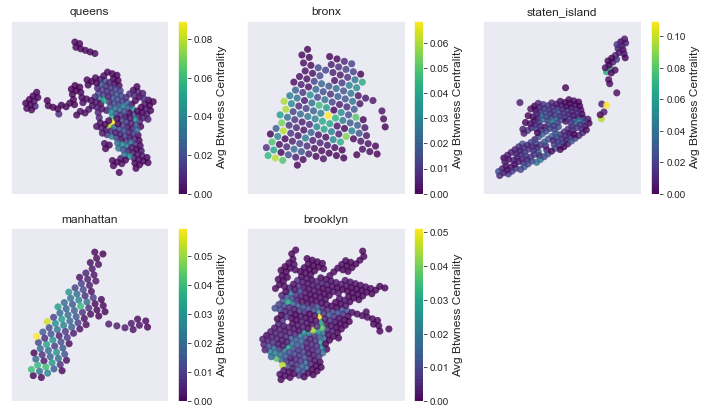

In [218]:
i = 1
plt.subplots(figsize = (12,7))

for k,v in nyc_bus_avg_cent.items():
    # plot the hexs
    plt.subplot(230 + i)
    plt.scatter(x=v.lng, y=v.lat, c=v['avg_centrality'],
                edgecolors='none', cmap='viridis', marker='o', alpha=.8, s=50)
    plt.title(k)
    plt.colorbar().set_label('Avg Btwness Centrality', size=12)
    plt.xticks([], [])
    plt.yticks([], [])
    i += 1

#### Visualize the smoothed results

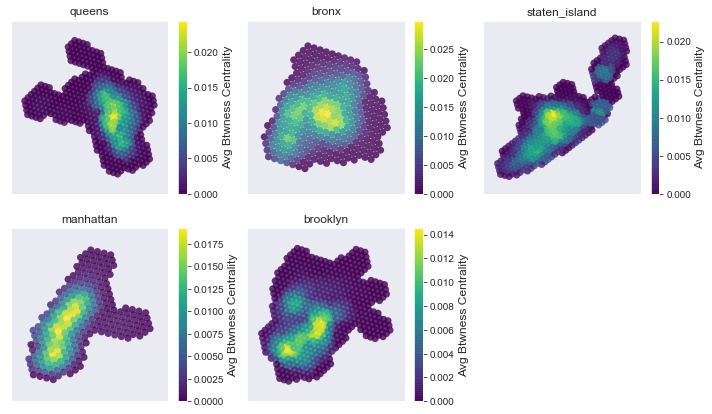

In [17]:
i = 1
plt.subplots(figsize = (12,7))

for k,v in nyc_bus_avg_cent.items():
    # kring_smoothing
    smooth = kring_smoothing(v, hex_col, metric_col='avg_centrality', k=2)
    # print('sum sanity check:', subway_centrality_smooth['avg_centrality'].sum() / subway_centrality_avg['avg_centrality'].sum()) 
    
    plt.subplot(230 + i)
    plt.scatter(x=smooth.lng, y=smooth.lat, c=smooth['avg_centrality'],
                    edgecolors='none', cmap='viridis', marker='o', alpha=.8, s=50)
    plt.title(k)
    plt.colorbar().set_label('Avg Btwness Centrality', size=12)
    plt.xticks([], [])
    plt.yticks([], [])
    i += 1

#### Merge smoothed data into one dataframe

In [18]:
nyc_bus_overall = pd.DataFrame(columns=['hex8','avg_centrality','lat','lng'])
for k,v in nyc_bus_avg_cent.items():
#     print(len(v))
    nyc_bus_overall = pd.concat([nyc_bus_overall, v])

In [19]:
nyc_bus_overall.columns

Index(['hex8', 'avg_centrality', 'lat', 'lng'], dtype='object')

In [27]:
# there are duplicate hex ids
# need to combine the values - using the mean value here
print('Duplicate hex IDs: ' + str(nyc_bus_overall['hex8'].duplicated().sum()))
nyc_bus_overall_avg = nyc_bus_overall.groupby('hex8').mean().reset_index()
# print(len(nyc_bus_overall_avg))

Duplicate hex IDs: 104


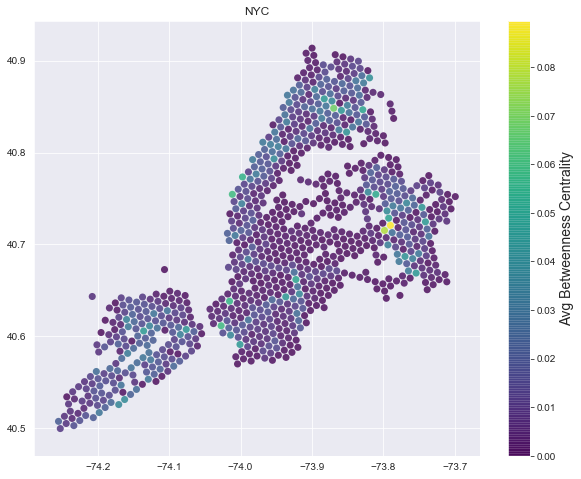

In [33]:
plt.figure(figsize=(10,8))
plt.scatter(x=nyc_bus_overall_avg.lng, y=nyc_bus_overall_avg.lat, c=nyc_bus_overall_avg['avg_centrality'],
                edgecolors='none', cmap='viridis', marker='o', alpha=.8, s=50)
plt.title('NYC');
plt.colorbar().set_label('Avg Betweenness Centrality', size=14)

#### Load NYC subway into a graph

In [40]:
gtfs_path = 'google_transit.zip'

In [41]:
# Automatically identify the busiest day and
# read that in as a Partidge feed
feed = pt.get_representative_feed(gtfs_path)

# Set a target time period to use to summarize impedance
start = 7*60*60  # 7:00 AM
end = 10*60*60  # 10:00 AM

# Convert feed subset into a directed network multigraph
G = pt.load_feed_as_graph(feed, start, end)

# check for bad nodes
bad_ns = [i for i, n in G.nodes(data=True) if n['x'] == 0]
print(len(bad_ns))

0


#### Calculate betweenness centrality and coordinates of nodes

In [42]:
# calculate btwness centrality
nodes = nx.betweenness_centrality(G)

In [43]:
# get lists of ids and values
nids = []
vals = []
for k in nodes.keys():
    nids.append(k)
    vals.append(nodes[k])
    
min(vals), np.array(vals).mean(), max(vals)

(0.0, 0.0006807145775760171, 0.0061463982596439625)

In [45]:
# get coordinates for each node
coords = []
for n in list(G.nodes(data=True)):
    coords.append((n[1]['y'],n[1]['x']))

assert len(coords) == len(nids)

In [46]:
# organize in a dataframe
node_data = []
for val, coord in zip(vals, coords):
    node_data.append([val, coord[0], coord[1]])

subway_centrality = pd.DataFrame(node_data, columns=['centrality','lat','lng'])

In [48]:
APERTURE_SIZE = 8
hex_col = 'hex'+str(APERTURE_SIZE)

# add hex id to each point
subway_centrality[hex_col] = subway_centrality.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, APERTURE_SIZE), 1)

In [49]:
subway_centrality.head()

,centrality,lat,lng,hex8
0,0.000000,40.889248,-73.898583,882a100a5bfffff
1,0.000000,40.889248,-73.898583,882a100a5bfffff
2,0.000066,40.884667,-73.900870,882a100a53fffff
3,0.000066,40.884667,-73.900870,882a100a53fffff
4,0.000131,40.878856,-73.904834,882a100a19fffff


#### Aggregate the points, using the mean value for each h3 cell

In [50]:
subway_centrality_avg = subway_centrality.groupby(hex_col).mean()['centrality'].to_frame('avg_centrality').reset_index()

In [56]:
# find center of hex for visualization
subway_centrality_avg['lat'] = subway_centrality_avg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
subway_centrality_avg['lng'] = subway_centrality_avg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [57]:
subway_centrality_avg.head()

,hex8,avg_centrality,lat,lng
0,882a100105fffff,0.000475,40.877383,-73.868416
1,882a100107fffff,0.000607,40.869503,-73.865981
2,882a10010bfffff,0.000186,40.872647,-73.846787
3,882a10010dfffff,0.000384,40.882896,-73.860035
4,882a100115fffff,0.000276,40.859257,-73.852736


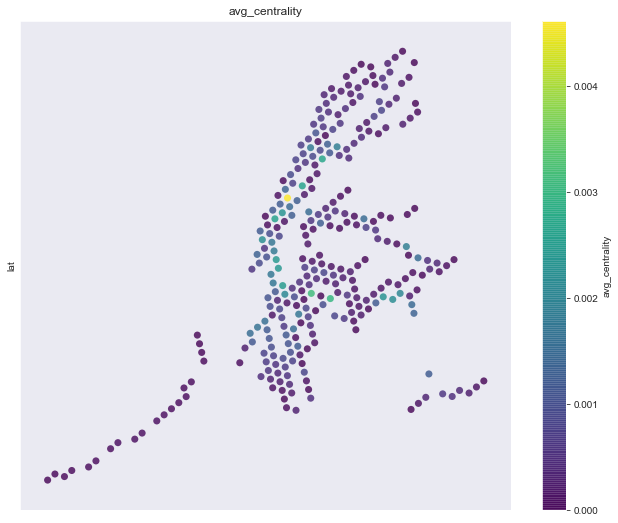

In [58]:
# plot the hexs
plot_scatter(subway_centrality_avg, metric_col='avg_centrality', marker='o', alpha=.8, figsize=(11,9), s=50)

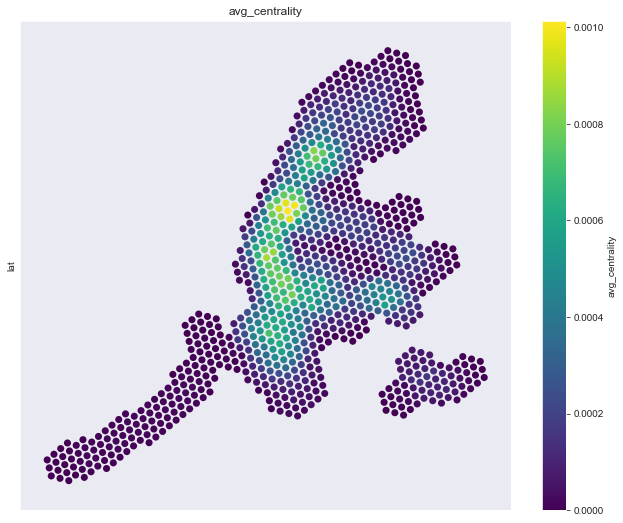

In [63]:
# smoothed data
k = 2
subway_centrality_smooth = kring_smoothing(subway_centrality_avg, hex_col, metric_col='avg_centrality', k=k)
# print('sum sanity check:', subway_centrality_smooth['avg_centrality'].sum() / subway_centrality_avg['avg_centrality'].sum()) 
plot_scatter(subway_centrality_smooth, metric_col='avg_centrality', marker='o', s=50)

In [64]:
subway_centrality_smooth.head()

,hex8,avg_centrality,lat,lng
0,882a100021fffff,0.000003,40.857656,-73.811927
1,882a100023fffff,0.000003,40.849777,-73.809503
2,882a100025fffff,0.000003,40.860027,-73.822736
3,882a100027fffff,0.000012,40.852149,-73.820309
4,882a10002dfffff,0.000000,40.865536,-73.814352


In [84]:
# compare max and median values
print('      ','max','                median')
print('subway', subway_centrality_smooth['avg_centrality'].max(), subway_centrality_smooth['avg_centrality'].median())
print('bus   ', nyc_bus_overall_avg.avg_centrality.max(), nyc_bus_overall_avg.avg_centrality.median())

       max                 median
subway 0.10128499133874047 0.008461407934559975
bus    0.08951399271770419 0.005937899258920314


In [147]:
# multiply by 100 to bring subway max to same order of magnitude as bus
subway_centrality_smooth['avg_centrality'] = subway_centrality_smooth['avg_centrality'] * 100

In [103]:
# log transform to smooth out the differences
def absLog(x):
    return np.abs(np.log(x))

In [106]:
subway_log = subway_centrality_smooth.avg_centrality.apply(lambda x: absLog(x) if x != 0 else x)
bus_log = nyc_bus_overall_avg.avg_centrality.apply(lambda x: absLog(x) if x != 0 else x)

In [137]:
bus_log.mean()

5.477763918584868

In [138]:
# give subway more weight
subway_centrality_smooth['log_centrality'] = subway_log * 2
nyc_bus_overall_avg['log_centrality'] = bus_log

In [148]:
# take the mean of subway and bus
nyc_overall = pd.concat([subway_centrality_smooth, nyc_bus_overall_avg]).groupby('hex8').mean().reset_index()

In [149]:
len(nyc_overall)

1187

In [150]:
nyc_overall.head()

,hex8,avg_centrality,lat,lng,log_centrality
0,882a100007fffff,0.002457,40.852911,-73.790314,6.008971
1,882a100021fffff,0.033865,40.857656,-73.811927,15.981067
2,882a100023fffff,0.033865,40.849777,-73.809503,15.981067
3,882a100025fffff,0.018597,40.860027,-73.822736,10.843223
4,882a100027fffff,0.116379,40.852149,-73.820309,13.512155


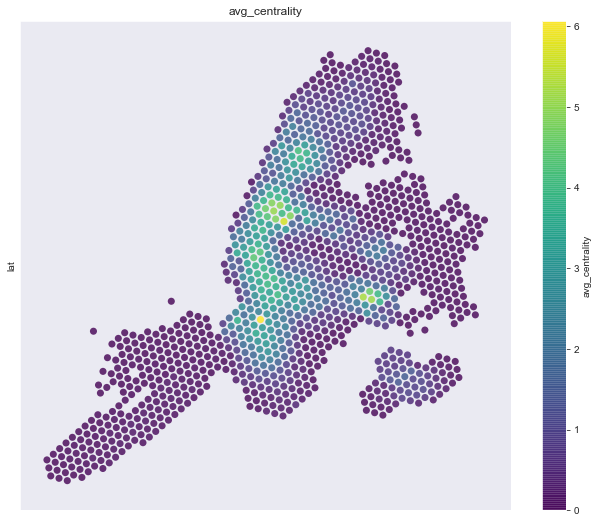

In [151]:
# plot the hexs
plot_scatter(nyc_overall, metric_col='avg_centrality', marker='o', alpha=.8, figsize=(11,9), s=50)

#### Load transit score data

In [152]:
d = pd.read_csv('wtb_nyc.csv', index_col='Unnamed: 0')

In [153]:
d.head()

,hex8,avg_centrality,lat,lng,walk,transit,bike
0,882a100007fffff,0.002457,40.852911,-73.790314,53,37.0,55
1,882a100021fffff,0.000339,40.857656,-73.811927,3,63.0,44
2,882a100023fffff,0.000339,40.849777,-73.809503,4,36.0,27
3,882a100025fffff,0.001833,40.860027,-73.822736,49,85.0,68
4,882a100027fffff,0.001164,40.852149,-73.820309,24,84.0,59


In [154]:
len(d)

1187

Text(0, 0.5, 'log(centrality)')

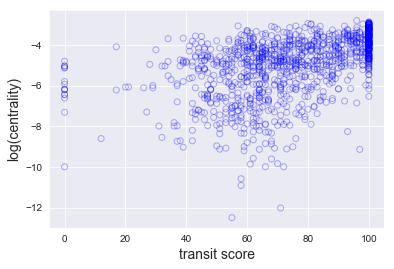

In [157]:
plt.scatter(d.transit, np.log(d.avg_centrality), marker='o', \
            facecolors='none', edgecolors='blue', alpha=.3)
plt.xlabel('transit score', size=14)
plt.ylabel('log(centrality)', size=14)

#### Transit is reasonable correlated with centrality, as expected

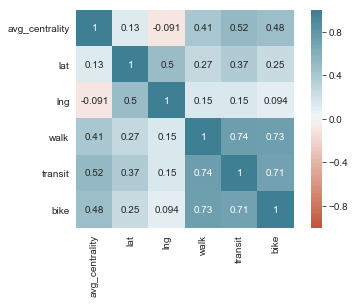

In [158]:
corr = d.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

#### Map h3 cells with KeplerGL

In [163]:
d.rename(columns={'hex8':'hex_id'}, inplace=True)

In [237]:
with open('kepler_config.json') as f:
    config = json.load(f)

In [239]:
map_1 = KeplerGl(config=config)
map_1.add_data(d, 'centrality')
map_1

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'config': {'mapState': {'bearing': 0, 'dragRotate': False, 'isSplit': False, 'latitude': 40.7…

#### Load NYC neighborhood boundaries and rent data

In [195]:
# boundaries
nb = gpd.read_file('neighbs.geojson', driver='GeoJSON')

In [196]:
# load asking rent data
nb_data = pd.read_csv('medianAskingRent_All.csv')
nb_data = nb_data[nb_data.areaType == 'neighborhood']

In [197]:
# merge data and geom
nb_data_geom = nb_data.merge(nb, right_on=['Borough','name'], left_on=['Borough','areaName'], how='left')

In [198]:
# grab just the most recent month
nb_data_latest = nb_data_geom.iloc[:,-6:]

In [199]:
nb_data_latest.head()

,2019-09,id,area_id,area_type,name,geometry
0,2350.0,63,401.0,neighborhood,Astoria,"POLYGON ((-73.90625216878121 40.7598827423752,..."
1,2195.0,83,431.0,neighborhood,Auburndale,POLYGON ((-73.80465306720144 40.73838317004601...
2,1795.0,274,336.0,neighborhood,Bath Beach,POLYGON ((-74.02132449357453 40.60352548475039...
3,4695.0,197,112.0,neighborhood,Battery Park City,POLYGON ((-74.01371716346075 40.71382763843926...
4,1895.0,269,331.0,neighborhood,Bay Ridge,POLYGON ((-74.03566843529508 40.64052056823991...


In [200]:
nb_data_latest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 0 to 176
Data columns (total 6 columns):
2019-09      123 non-null float64
id           175 non-null object
area_id      175 non-null float64
area_type    175 non-null object
name         175 non-null object
geometry     175 non-null geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 9.7+ KB


In [201]:
nb_data_latest.crs = {"init": "epsg:4326"}
nb_data_latest_gdf = gpd.GeoDataFrame(nb_data_latest)

#### Visualize median rents for Sept 2019

Text(0.5, 1.0, 'Median Rent by Neighborhood')

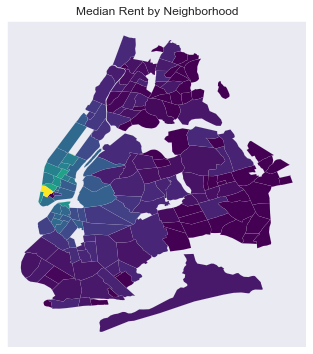

In [205]:
f, ax = plt.subplots(figsize=(6,6))
ax.get_xaxis().set_visible(False) 
ax.get_yaxis().set_visible(False)
nb_data_latest_gdf.plot(column='2019-09',colormap='viridis',alpha=1,linewidth=0.05,ax=ax)
plt.title('Median Rent by Neighborhood')

In [207]:
nb_data_latest_gdf.dropna(inplace=True)

#### Generate h3 cells from rent data

Text(0.5, 1.0, 'hex-grid: median rent $')

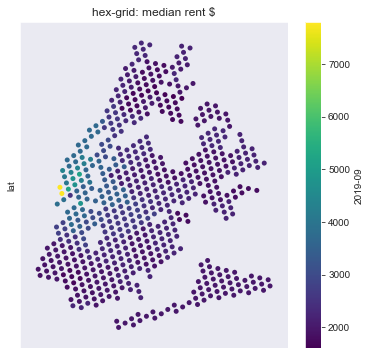

In [210]:
APERTURE_SIZE = 8 

# Unify the neighborhood boundries
union_poly = cascaded_union(nb_data_latest_gdf.geometry)

# Find the hexs within the city boundary using PolyFill
hex_list=[]
for n,g in enumerate(union_poly):
#     print(n,'\r',)
    temp = mapping(g)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp, APERTURE_SIZE))

# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list,columns=[hex_col])
# print('Sanity Check\nnumber of hexes:', len(hex_list))
# print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

# add lat, lng at center of hex 
dfh['lat'] = dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng'] = dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)
dfh.crs = {"init": "epsg:4326"}

# Intersect hex point with neighborhood polygon
df_nb = geopandas.tools.sjoin(nb_data_latest_gdf, GeoDataFrame(dfh), how="inner")
df_nb.sample(3)

# Visualize hexagons
plot_scatter(pd.DataFrame(df_nb), metric_col='2019-09', marker='.', s=100, figsize=(6,6))
plt.title('hex-grid: median rent $')

In [211]:
# Join transit to rent data
df_rent_transit = df_nb.merge(d[['hex_id','avg_centrality','transit']], left_on='hex8', right_on='hex_id')

#### Centrality reasonably positively correlated with rent, transit score less so


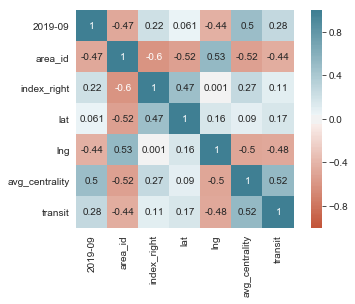

In [214]:
corr = df_rent_transit.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

Text(0.5, 1.0, 'Rent / Centrality')

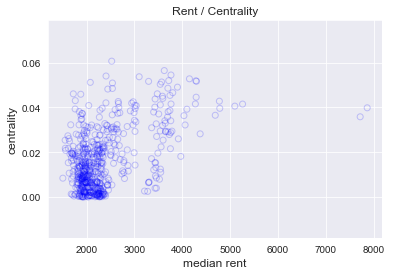

In [244]:
rent_jitter = df_rent_transit['2019-09'].apply(lambda x: x + np.random.uniform(-100,100))
plt.scatter(rent_jitter, df_rent_transit.avg_centrality, marker='o', \
            facecolors='none', edgecolors='blue', alpha=.2)
plt.xlabel('median rent', size=12)
plt.ylabel('centrality', size=12)
plt.title('Rent / Centrality')

Text(0.5, 1.0, 'Rent / Transit Score')

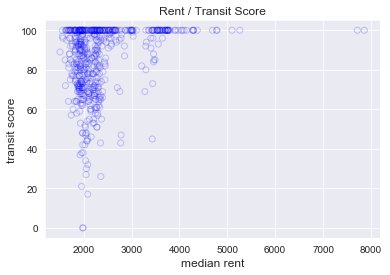

In [245]:
plt.scatter(rent_jitter, df_rent_transit.transit, marker='o', \
            facecolors='none', edgecolors='blue', alpha=.2)
plt.xlabel('median rent', size=12)
plt.ylabel('transit score', size=12)
plt.title('Rent / Transit Score')